Aprendizaje Activo.-

El aprendizaje activo (Active Learning) en machine learning es un enfoque en el que el algoritmo de aprendizaje interactúa con un usuario (o "oráculo") para solicitar las etiquetas de los datos más informativos, con el objetivo de mejorar su rendimiento utilizando menos ejemplos etiquetados.

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from PIL import Image
import matplotlib.pyplot as plt

train_images_dir = '/Users/diego/Desktop/LAB_5_IA/train_images'
test_images_dir = '/Users/diego/Desktop/LAB_5_IA/test_imagenes'

#test imagenes = 8000

#train imagenes = 5000

#sin etiquetas = 10000

Función para cargar imágenes sin etiquetas

In [22]:
def load_images_unlabeled(folder_path, image_size=(96, 96)):
    X = []
    for filename in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        if not os.path.isfile(img_path):
            continue
        try:
            img = Image.open(img_path).convert('RGB').resize(image_size)
            X.append(np.array(img))
        except Exception as e:
            print(f"Error al cargar imagen {img_path}: {e}")

    return np.array(X)

X_train = load_images_unlabeled(train_images_dir)
print("Train:", X_train.shape)

Train: (5000, 96, 96, 3)


Aplanar y normalizar imágenes

In [23]:
X_train_flat_full = X_train.reshape(X_train.shape[0], -1).astype(float) / 255.0

Simular etiquetas manuales y entrenar modelo base

In [24]:
etiquetas = ['gato'] * 20 + ['perro'] * 20 + ['pajaro'] * 20 + ['avion'] * 20 + ['caballo'] * 20

log_reg2 = OneVsRestClassifier(LogisticRegression(solver="lbfgs", max_iter=5000, random_state=42))
X_representative_flat = X_train_flat_full[:100]
y_representative_labels = np.array(etiquetas)
log_reg2.fit(X_representative_flat, y_representative_labels)

y_train_propagated = log_reg2.predict(X_train_flat_full)

Entrenar modelo con etiquetas propagadas y calcular incertidumbre

In [25]:
N = 1000
k = 10
X_pool = X_train_flat_full[:N]
y_pool = y_train_propagated[:N]

log_reg3 = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=5000, random_state=42))
log_reg3.fit(X_pool, y_pool)

probas = log_reg3.predict_proba(X_pool)
labels_ixs = np.argmax(probas, axis=1)
labels = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
sorted_ixs = np.argsort(labels)
print("Las 10 probabilidades más bajas:", labels[sorted_ixs[:10]])

Las 10 probabilidades más bajas: [0.92633455 0.94946307 0.9495737  0.95140819 0.95393357 0.95458829
 0.95942105 0.96118119 0.9619732  0.96247508]


Función para pedir etiquetas manuales

In [26]:
def pedir_etiquetas_manual(total):
    etiquetas_input = input(f"Introduce {total} etiquetas separadas por comas:\n> ").strip()
    etiquetas = [et.strip() for et in etiquetas_input.split(",")]
    
    if len(etiquetas) != total:
        print(f"❌ Error: se esperaban {total} etiquetas, pero se recibieron {len(etiquetas)}.")
        return pedir_etiquetas_manual(total)

    return np.array(etiquetas)

Visualizar las muestras más inciertas

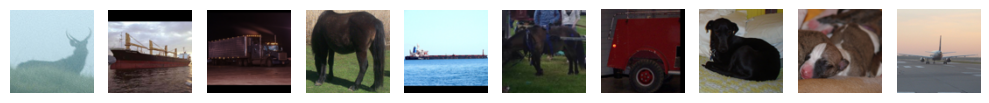

In [29]:
x_lowest = X_train[:N][sorted_ixs[:k]]
plt.figure(figsize=(10, 4))
for index, img in enumerate(x_lowest):
    plt.subplot(1, k, index + 1)
    plt.imshow(img.astype(np.uint8).reshape(96, 96, 3), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.tight_layout()
plt.show()

Obtener etiquetas corregidas para esas muestras

In [30]:
try:
    y_lowest = y_train[:N][sorted_ixs[:k]]
except:
    y_lowest = pedir_etiquetas_manual(k)

print("Etiquetas para las muestras más inciertas:", y_lowest)

Etiquetas para las muestras más inciertas: ['ciervo' 'barco' 'camion' 'caballo' 'barco' 'caballo' 'carro' 'perro'
 'perro' 'avion']


Actualizar las etiquetas propagadas con las nuevas

In [31]:
y_train2 = y_train_propagated[:N].copy()
y_train2[sorted_ixs[:k]] = y_lowest

Cargar imágenes de prueba desde carpetas por clase

In [32]:
X_test_list, y_test = [], []
for cls in sorted(os.listdir(test_images_dir)):
    cls_dir = os.path.join(test_images_dir, cls)
    if not os.path.isdir(cls_dir):
        continue
    for fname in sorted(os.listdir(cls_dir)):
        path = os.path.join(cls_dir, fname)
        try:
            img = Image.open(path).convert('RGB').resize((96, 96))
            X_test_list.append(np.array(img))
            y_test.append(cls)
        except Exception as e:
            print(f"⚠️ No se pudo cargar: {path} — {e}")

X_test = np.array(X_test_list)
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(float) / 255.0
y_test = np.array(y_test)

print("Test data cargado:", X_test.shape)
print("Clases en test:", np.unique(y_test))

Test data cargado: (627, 96, 96, 3)
Clases en test: ['avion' 'barco' 'caballo' 'camion' 'ciervo' 'coche' 'gato' 'mono'
 'pajaro' 'perro']


Reentrenar modelo con las correcciones

In [33]:
log_reg5 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg5.fit(X_pool, y_train2)

acc = log_reg5.score(X_test_flat, y_test)
print(f"Accuracy tras reentrenar con Active Learning: {acc:.4f}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: total: 4min 7s
Wall time: 51.3 s
Accuracy tras reentrenar con Active Learning: 0.1308


Matriz de confusión del modelo final

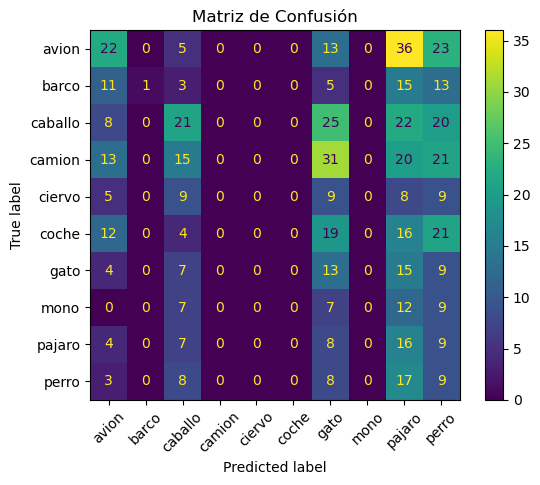

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = log_reg5.predict(X_test_flat)

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()


 Gráfico de precisión por clase

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


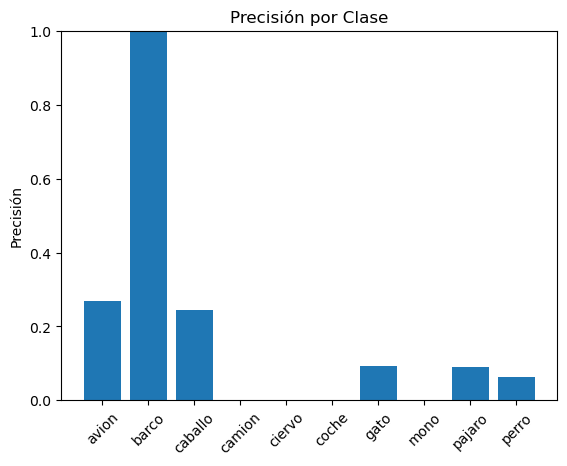

In [35]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)
classes = list(report.keys())[:-3]
scores = [report[cls]['precision'] for cls in classes]

plt.bar(classes, scores)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Precisión")
plt.title("Precisión por Clase")
plt.show()
